# Optimasi Sistem Penjadwalan Antrian Teller Bank Berbasis Algoritma Genetika

### Oleh Kelompok 13
- Lani Nur Patria
- Muhammad Rizqi Winnel Adnin
- Rizka Nurhidayati
- Salsya Fadillah R


##  Deskripsi Algoritma Genetika

Algoritma genetika (GA) merupakan algoritma yang berbasis populasi yang memungkinkan digunakan pada masalah optimasi dengan ruang pencarian (search space) yang sangat luas dan kompleks. Properti ini juga memungkinkan GA untuk melompat keluar dari daerah optimum lokal.

GA terdiri dari tahapan utama:
1. Representasi solusi/kromosom (encoding)
2. Pembangkitan populasi
3. Perhitungan nilai fitness
4. Seleksi
5. Crossover
6. Mutasi


Import library yang diperlukan

- random: untuk mengenerate bilangan secara random
- matplotlib.pyplot: untuk membuat visualisasi tabel
- numpy: digunakan untuk menyusun jam pada visualisasi

In [73]:
import random
import matplotlib.pyplot as plt
import numpy as np

##  Parameter & Data Masukan

Berikut merupakan keterangan dari parameter yang tersedia

- JML_JAM: Jumlah jam kerja operasional bank
- MAKS_TELLER: Jumlah maksimum teller yang bekerja pada bank
- MIN_TELLER: Jumlah minimum teller yang bekerja pada bank
- UK_POP: Ukuran Populasi
- BYK_GENERASI: Banyak generasi (iterasi) pada proses perhitungan Genetic Algorithm 
- nasabah_per_jam: Jumlah (rata-rata) nasabah yang datang per jam
- LAYANAN_PER_TELLER: Jumlah Kapasitas Nasabah yang dapat dilayani oleh satu teller per jam

Dalam hal ini, untuk penelitian ini digunakan paramater sebagai berikut

- Jam operasional: 08:00–16:00 (8 jam)
- Jumlah teller minimum dan maksimum per jam: 1–5
- Setiap teller dapat melayani hingga 5 nasabah per jam
- Data nasabah per jam disimulasikan sebagai list `[10, 15, 20, 25, 18, 14, 10, 8]`

In [74]:
JML_JAM = 8
MAKS_TELLER = 5
MIN_TELLER = 1
UK_POP = 10
BYK_GENERASI = 60
nasabah_per_jam = [10, 15, 20, 25, 18, 14, 10, 8]
LAYANAN_PER_TELLER = 5

## Pengodean/Pembentukan Kromosom (Encoding)

Setiap kromosom direpresentasikan sebagai list sepanjang 8 (jumlah jam), dengan tiap elemen menyatakan jumlah teller yang bekerja di jam tersebut:

Contoh:
`[3, 4, 5, 5, 4, 3, 2, 2]`

Arti:
- Jam 08:00–09:00 -> 3 teller aktif
- Jam 09:00–10:00 -> 4 teller aktif
- ... dan seterusnya

In [75]:
# -- Fungsi Generate Kromosom --
def generate_kromosom():
    return [random.randint(MIN_TELLER, MAKS_TELLER) for _ in range(JML_JAM)]

# Contoh
krom_contoh = generate_kromosom()
print(f"Contoh satu kromosom: {krom_contoh}")

Contoh satu kromosom: [1, 2, 1, 4, 3, 4, 1, 5]


##  Pembangkitan Populasi Awal

Populasi awal dihasilkan secara acak. Setiap kromosom adalah kandidat solusi yang akan dievolusikan oleh algoritma.

In [85]:
# -- Fungsi Inisialisasi Populasi --
def inisialisasi_populasi():
    return [generate_kromosom() for _ in range(UK_POP)]

# Contoh keluaran hasil
def show_inisialisasi_populasi(population):
    print("Populasi Awal:")
    for i, krom in enumerate(population):
        print(f"Kromosom {i+1}: {krom}")

population = inisialisasi_populasi()
show_inisialisasi_populasi(population)

Populasi Awal:
Kromosom 1: [4, 2, 4, 3, 1, 2, 3, 1]
Kromosom 2: [2, 1, 1, 4, 3, 5, 2, 4]
Kromosom 3: [3, 3, 2, 1, 4, 3, 2, 2]
Kromosom 4: [5, 1, 3, 4, 1, 1, 4, 3]
Kromosom 5: [5, 5, 5, 2, 5, 2, 1, 4]
Kromosom 6: [4, 3, 2, 5, 1, 1, 1, 4]
Kromosom 7: [4, 1, 5, 3, 2, 5, 4, 5]
Kromosom 8: [2, 5, 3, 5, 1, 1, 5, 5]
Kromosom 9: [4, 1, 3, 3, 4, 4, 1, 3]
Kromosom 10: [3, 4, 2, 2, 4, 1, 2, 4]


## Perhitungan Nilai Fitness

Nilai fitness dari setiap kromosom dihitung berdasarkan total constraint pelayanan (waktu tunggu dan mengganggur).

- Waktu tunggu: nasabah - kapasitas
- Menganggur: kapasitas - nasabah (dihitung dengan bobot ringan α = 0.2)

### Rumus:

Waktu Tunggu:
$$
\sum_{j=1}^{n} \left[ \max(0, D_j - K_j) \right]
$$

Menganggur:
$$
\sum_{j=1}^{n} \left[ \alpha \cdot \max(0, K_j - D_j) \right]
$$

Total Penalti:
$$
\text{Penalti} = \text{Waktu Tunggu} + \text{Menganggur} 
$$

Fitness:
$$
\text{Fitness} = \frac{1}{1 + \text{Penalti}}
$$

Dengan notasi:
- $$ n: \text{jumlah jam operasional}$$
- $$ t_j: \text{jumlah teller yang bekerja pada jam ke-j} $$
- $$ D_j: \text{jumlah nasabah yang datang pada jam ke-j} $$
- $$ r: \text{jumlah nasabah yang bisa dilayani 1 teller per jam} $$
- $$ K_j = r \cdot t_j: \text{total kapasitas pelayanan di jam ke-j} $$


In [77]:
# -- Fungsi Count Penalti --
def hitung_penalti(krom, nasabah_per_jam):
    penalti = 0
    for j in range(JML_JAM):
        kapasitas = krom[j] * LAYANAN_PER_TELLER
        nasabah = nasabah_per_jam[j]
        if kapasitas < nasabah:
            penalti += (nasabah - kapasitas)  
        elif kapasitas > nasabah:
            penalti += 0.2 * (kapasitas - nasabah) 
    return penalti

# -- Fungsi Fitness --
def fitness(krom, nasabah_per_jam):
    constraint = hitung_penalti(krom, nasabah_per_jam)
    return 1 / (1 + constraint)

def show_pembangkitan_populasi_dengan_fitness(population, nasabah_per_jam):
    print("Populasi Awal dan Nilai Fitness:")
    for i, chrom in enumerate(population):
        fit = fitness(chrom, nasabah_per_jam)
        print(f"Kromosom {i+1}: {chrom}  Fitness = {fit:.4f}")

fitnesses = [fitness(chrom, nasabah_per_jam) for chrom in population]
show_pembangkitan_populasi_dengan_fitness(population, nasabah_per_jam)

Populasi Awal dan Nilai Fitness:
Kromosom 1: [3, 5, 1, 4, 3, 5, 4, 1]  Fitness = 0.0292
Kromosom 2: [5, 1, 3, 5, 5, 3, 2, 2]  Fitness = 0.0476
Kromosom 3: [5, 2, 1, 1, 5, 4, 4, 2]  Fitness = 0.0204
Kromosom 4: [3, 4, 1, 3, 1, 1, 1, 4]  Fitness = 0.0174
Kromosom 5: [4, 5, 1, 5, 5, 4, 4, 3]  Fitness = 0.0385
Kromosom 6: [1, 4, 2, 1, 2, 1, 3, 3]  Fitness = 0.0177
Kromosom 7: [3, 2, 3, 1, 5, 3, 1, 2]  Fitness = 0.0256
Kromosom 8: [4, 5, 3, 3, 1, 2, 2, 4]  Fitness = 0.0254
Kromosom 9: [1, 2, 2, 2, 2, 1, 3, 1]  Fitness = 0.0175
Kromosom 10: [3, 4, 2, 1, 4, 2, 4, 5]  Fitness = 0.0234


## Seleksi: Tournament Selection

Beberapa individu (misal 3) dipilih secara acak dan dibandingkan nilai fitness-nya. Individu terbaik dipilih untuk jadi parent.


In [78]:
# -- Fungsi Seleksi Tournament --
def tournament_selection(population, fitnesses, ukuran_tournament=3):
    terpilih = random.sample(list(zip(population, fitnesses)), ukuran_tournament)
    terpilih.sort(key=lambda x: x[1], reverse=True)  
    return terpilih[0][0].copy()  

# -- Fungsi Contoh Seleksi Tournament --
def show_tournament_selection(population, fitnesses, ukuran_tournament=3):
    print("Contoh Seleksi Tournament:")
    terpilih = random.sample(list(zip(population, fitnesses)), ukuran_tournament)
    for i, (chrom, fit) in enumerate(terpilih):
        print(f"  Peserta {i+1}: {chrom}, Fitness: {fit:.4f}")
    terpilih.sort(key=lambda x: x[1], reverse=True)
    print("   Terpilih:", terpilih[0][0])

show_tournament_selection(population, fitnesses)


Contoh Seleksi Tournament:
  Peserta 1: [5, 2, 1, 1, 5, 4, 4, 2], Fitness: 0.0204
  Peserta 2: [1, 4, 2, 1, 2, 1, 3, 3], Fitness: 0.0177
  Peserta 3: [3, 2, 3, 1, 5, 3, 1, 2], Fitness: 0.0256
   Terpilih: [3, 2, 3, 1, 5, 3, 1, 2]


## Crossover

Dua parent disilangkan dengan metode *uniform crossover*, di mana setiap gen (jam) punya peluang 50% untuk ditukar antar parent.

Tujuannya adalah menghasilkan keturunan (child) yang menggabungkan karakteristik baik dari kedua parent.


In [ ]:
# -- Fungsi Crossover --
def crossover(parent1, parent2):
    child1 = []
    child2 = []
    for g1, g2 in zip(parent1, parent2):
        if random.random() < 0.5:
            child1.append(g1)
            child2.append(g2)
        else:
            child1.append(g2)
            child2.append(g1)
    return child1, child2

# -- Fungsi Contoh Crossover --
def show_crossover(parent1, parent2, child1, child2):
    print("Contoh Crossover:")
    print("  Parent 1 :", parent1)
    print("  Parent 2 :", parent2)
    print("   Child 1 :", child1)
    print("   Child 2 :", child2)

p1 = tournament_selection(population, fitnesses)
p2 = tournament_selection(population, fitnesses)
while p1 == p2:
    p2 = tournament_selection(population, fitnesses)
c1, c2 = crossover(p1, p2)
show_crossover(p1, p2, c1, c2)



Contoh Crossover:
  Parent 1 : [3, 5, 1, 4, 3, 5, 4, 1]
  Parent 2 : [4, 5, 1, 5, 5, 4, 4, 3]
    Child 1: [4, 5, 1, 5, 5, 4, 4, 3]
    Child 2: [3, 5, 1, 4, 3, 5, 4, 1]


## Mutasi

Mutasi dilakukan dengan metode *random resetting mutation*, Setiap gen dari kromosom memiliki peluang untuk berubah nilainya secara acak.

Tujuannya adalah mempertahankan keragaman populasi dan mencegah solusi macet pada lokal optimum.


In [80]:
# -- Fungsi Mutasi --
def mutasi(krom, mutation_rate=0.1):
    krom = krom.copy()
    for i in range(JML_JAM):
        if random.random() < mutation_rate:
            krom[i] = random.randint(MIN_TELLER, MAKS_TELLER)
    return krom

# -- Contoh Mutasi --
def show_mutasi(original, mutant):
    print("\n Mutasi:")
    print("  Sebelum:", original)
    print("  Sesudah:", mutant)

mutant = mutasi(c1)
show_mutasi(c1, mutant)



 Mutasi:
  Sebelum: [4, 5, 1, 5, 5, 4, 4, 3]
  Sesudah: [4, 5, 1, 5, 5, 4, 4, 3]


##  Evolusi Generasi

Setiap generasi:
1. Populasi dinilai berdasarkan fitness
2. Elitisme diterapkan (individu terbaik dipertahankan)
3. Parent dipilih dan dikawinkan sehingga Child dihasilkan
4. Child mengalami mutasi dan membentuk generasi baru

In [81]:
# -- Fungsi evolusi generasi
def evolusi_generasi(population, nasabah_per_jam):
    fitnesses = [fitness(chrom, nasabah_per_jam) for chrom in population]
    new_pop = []

    # Elitism
    best_idx = fitnesses.index(max(fitnesses))
    new_pop.append(population[best_idx].copy())

    while len(new_pop) < UK_POP:
        p1 = tournament_selection(population, fitnesses)
        p2 = tournament_selection(population, fitnesses)
        while p1 == p2:
            p2 = tournament_selection(population, fitnesses)
        c1, c2 = crossover(p1, p2)
        new_pop.append(mutasi(c1))
        if len(new_pop) < UK_POP:
            new_pop.append(mutasi(c2))
            
    return new_pop

## Fungsi Visualisasi

Visualisasi Nasabah per Jam vs Kapasitas Layanan

In [82]:
def visualisasi(krom, nasabah_per_jam, layanan_per_teller=5):
    kapasitas = [teller * layanan_per_teller for teller in krom]

    plt.figure(figsize=(10, 5))
    bar_width = 0.35

    index = np.arange(JML_JAM)
    plt.bar(index, nasabah_per_jam, bar_width, label='Nasabah per Jam', color='skyblue')
    plt.bar(index + bar_width, kapasitas, bar_width, label='Kapasitas Layanan', color='orange')

    plt.xlabel('Jam Ke-')
    plt.ylabel('Jumlah')
    plt.title('Perbandingan Nasabah vs Kapasitas Layanan')
    plt.xticks(index + bar_width / 2, [f'{8+i}:00' for i in range(JML_JAM)])
    plt.legend()
    plt.grid(axis='y', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

## Fungsi Run Algoritma Genetika

Fungsi utama yaitu run_ga() yang digunakan dalam melakukan proses Algoritma Genetika

In [83]:
def run_ga(generasi=BYK_GENERASI):
    populasi = inisialisasi_populasi()

    for gen in range(generasi):
        fitnesses = [fitness(krom, nasabah_per_jam) for krom in populasi]
        best_fit = max(fitnesses)
        print(f"Generasi {gen+1}: Fitness terbaik = {best_fit:.4f}")
        populasi = evolusi_generasi(populasi, nasabah_per_jam)

    best_idx = max(range(len(populasi)), key=lambda i: fitness(populasi[i], nasabah_per_jam))
    best = populasi[best_idx]
    print("\nSolusi terbaik ditemukan:")
    print("Jumlah teller per jam:", best)
    print("Fitness:", fitness(best, nasabah_per_jam))
    visualisasi(best, nasabah_per_jam)


## Program Utama

Panggil fungsi run_ga() dalam program utama

Generasi 1: Fitness terbaik = 0.0588
Generasi 2: Fitness terbaik = 0.0588
Generasi 3: Fitness terbaik = 0.0833
Generasi 4: Fitness terbaik = 0.0833
Generasi 5: Fitness terbaik = 0.1667
Generasi 6: Fitness terbaik = 0.1667
Generasi 7: Fitness terbaik = 0.2000
Generasi 8: Fitness terbaik = 0.2500
Generasi 9: Fitness terbaik = 0.2500
Generasi 10: Fitness terbaik = 0.2500
Generasi 11: Fitness terbaik = 0.2500
Generasi 12: Fitness terbaik = 0.2500
Generasi 13: Fitness terbaik = 0.2500
Generasi 14: Fitness terbaik = 0.2500
Generasi 15: Fitness terbaik = 0.2500
Generasi 16: Fitness terbaik = 0.2500
Generasi 17: Fitness terbaik = 0.2500
Generasi 18: Fitness terbaik = 0.2500
Generasi 19: Fitness terbaik = 0.2500
Generasi 20: Fitness terbaik = 0.2500
Generasi 21: Fitness terbaik = 0.2500
Generasi 22: Fitness terbaik = 0.2500
Generasi 23: Fitness terbaik = 0.2500
Generasi 24: Fitness terbaik = 0.2500
Generasi 25: Fitness terbaik = 0.3333
Generasi 26: Fitness terbaik = 0.3333
Generasi 27: Fitness 

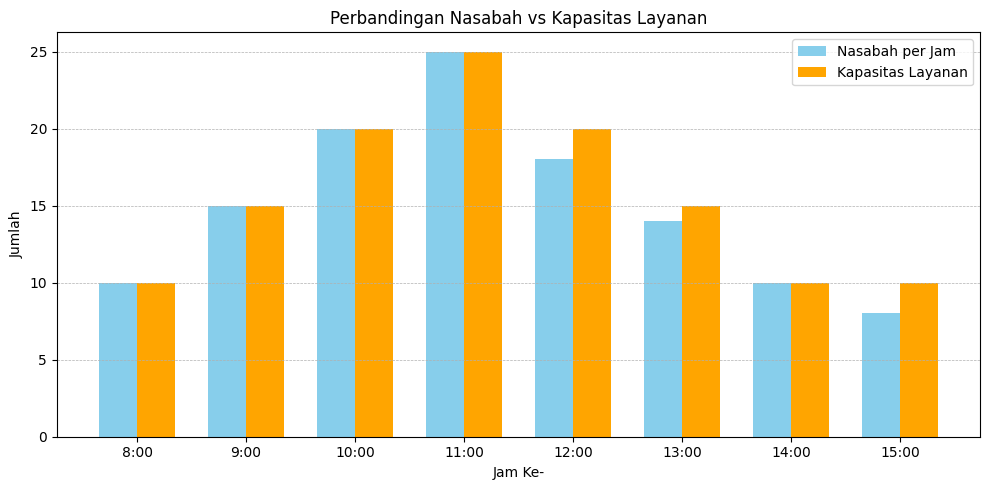

In [84]:
run_ga()